[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eneskelestemur/MolecularModeling/blob/main/Labs/lab06_deep_learning/Deep_learning.ipynb)

In [1]:
# Install the required packages
%pip install numpy pandas matplotlib keras tensorflow scikit-learn

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ----------------------------------- ---- 1.0/1.2 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 5.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/385.2 MB ? eta -:--:--
   ---------------------------------------- 1.0/385.2 MB 2.8 MB/s eta 0:02:18
   ---------------------------------------- 1.6/385.2 MB 3.0 MB/s eta 0:02:09
   ---------------------------------------- 2.1/385.2 MB 2.9 MB/s eta 0:02:11
   ---------------------------------------- 2.9/385.2 MB 2.8 MB/s eta 0:02:15
   ---------------------------------------- 3.4/385.2 MB 2.8 MB/s eta 0:02:15
   ---------------------------------------- 4.2/385.2 MB 2.9 MB/s eta 0:02:12
   ---------------------------------------- 4.7/385.2 MB 2.9 MB/s eta 0:02:11
    --------------------------------------- 5.5/385.2 MB 3.0 MB/s eta 0:02:08
    --------

# Deep Learning for Molecular Modeling

In this lab, we will explore fundamental deep learning concepts using the Keras library. We will cover:

* [Data Preprocessing](#data-preprocessing)
* [Basic Neural Networks](#basic-neural-networks)
* [1D Convolutional Neural Networks (CNNs) for Text Data](#1d-convolutional-neural-networks-cnns-for-text-data)
* [Overfitting vs Underfitting](#overfitting-vs-underfitting)
* [Regularization Methods](#regularization-methods)

## Data Preprocessing

Before we can build and train a deep learning model, we need to preprocess the data. This involves scaling the data, splitting it into training and testing sets, and converting it into a format suitable for neural networks. We will use the scikit-learn library for scaling and splitting the data.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

# Load dataset
df = pd.read_csv('data/curated_solubility_dataset.csv')

# to make the code faster, let's use only a subset of the data
df = df.sample(frac=0.1, random_state=42)

# Convert Mols to molecular fingerprints
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
def mols_to_fingerprints(mols, fp_gen=mfpgen, counts=False):
    feature_vectors = []
    for mol in mols:
        if counts:
            fp = fp_gen.GetCountFingerprint(mol)
        else:
            fp = fp_gen.GetFingerprint(mol)
        feature_vectors.append(fp)
    return np.array(feature_vectors)

df['Fingerprint'] = mols_to_fingerprints([Chem.MolFromSmiles(smi) for smi in df['SMILES']]).tolist()

# Prepare features (X) and target (y) for regression and classification
X = np.array(df['Fingerprint'].tolist())
X_smiles = df['SMILES'].values
y_regression = df['LogS']
y_classification = np.where(df['LogS'] < -3, 1, 0)  # Binary classification (-3 threshold)

# Split into train and test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=0.2, random_state=42)
X_train_smiles, X_test_smiles, y_train_smiles, y_test_smiles = train_test_split(X_smiles, y_regression, test_size=0.2, random_state=42)


## Basic Neural Networks

A neural network consists of layers of neurons, where each neuron performs a linear combination of inputs, followed by a non-linear activation function. We'll build a simple neural network for regression and classification tasks.

In [3]:
import keras
from keras import layers

# Building a simple neural network for regression
reg_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_reg.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Regression output
])

# Compiling the regression model
reg_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Training the regression model
history_reg = reg_model.fit(X_train_reg, y_train_reg, epochs=10, validation_split=0.2)


c:\Users\adamf\miniconda3\envs\MolecularModeling\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9.8209 - mean_absolute_error: 2.4439 - val_loss: 5.1562 - val_mean_absolute_error: 1.7649
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6223 - mean_absolute_error: 1.7007 - val_loss: 4.2272 - val_mean_absolute_error: 1.5696
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9831 - mean_absolute_error: 1.2422 - val_loss: 3.5562 - val_mean_absolute_error: 1.4379
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0007 - mean_absolute_error: 1.0503 - val_loss: 3.3014 - val_mean_absolute_error: 1.3329
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3862 - mean_absolute_error: 0.8016 - val_loss: 3.2296 - val_mean_absolute_error: 1.3444
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9175 - mean_absolute_error: 0.6202 - val_loss: 3.3030 - val_mean_absolute_error: 1.3276
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6144 - mean_absolute_error: 0.4851 - val_loss: 3.28

In [4]:
# Building a simple neural network for classification
class_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_class.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compiling the classification model
class_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the classification model
history_class = class_model.fit(X_train_class, y_train_class, epochs=10, validation_split=0.2)


Epoch 1/10


c:\Users\adamf\miniconda3\envs\MolecularModeling\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5467 - loss: 0.6878 - val_accuracy: 0.6327 - val_loss: 0.6587
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8358 - loss: 0.5646 - val_accuracy: 0.7075 - val_loss: 0.5902
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9415 - loss: 0.3840 - val_accuracy: 0.7211 - val_loss: 0.5442
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9633 - loss: 0.2081 - val_accuracy: 0.7483 - val_loss: 0.5613
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.1042 - val_accuracy: 0.7619 - val_loss: 0.6148
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9921 - loss: 0.0483 - val_accuracy: 0.7483 - val_loss: 0.6495
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0298 - val_accuracy: 0.7551 - val_loss: 0.7278
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0164 - val_accuracy: 0.7415 - val_loss: 0.7525
Ep

## 1D Convolutional Neural Networks (CNNs) for SMILES (Text Data)

SMILES strings, which represent the structure of chemical compounds, can be treated as text data. We will use a 1D CNN to classify these SMILES strings by first applying TextVectorization and embedding the SMILES into a vector space.

In [5]:
# Vectorize the SMILES strings
max_len = max(df['SMILES'].apply(len))
vectorizer = layers.TextVectorization(max_tokens=5000, output_sequence_length=max_len)
vectorizer.adapt(df['SMILES'].values)

# Build a 1D CNN for SMILES regression
smiles_model = keras.Sequential([
    vectorizer,
    layers.Embedding(input_dim=5000, output_dim=50, input_length=max_len),
    layers.Conv1D(128, kernel_size=5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Regression output
])

# Compile the 1D CNN model
smiles_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model using SMILES data for classification
history_smiles = smiles_model.fit(X_train_smiles, y_train_smiles, epochs=10, validation_split=0.2)


Epoch 1/10


c:\Users\adamf\miniconda3\envs\MolecularModeling\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 11.9448 - mean_absolute_error: 2.6536 - val_loss: 6.4780 - val_mean_absolute_error: 2.1443
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0320 - mean_absolute_error: 2.1297 - val_loss: 5.7039 - val_mean_absolute_error: 1.9271
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5901 - mean_absolute_error: 1.8791 - val_loss: 5.6800 - val_mean_absolute_error: 1.9245
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9501 - mean_absolute_error: 1.9303 - val_loss: 5.6755 - val_mean_absolute_error: 1.9234
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2076 - mean_absolute_error: 1.9385 - val_loss: 5.5721 - val_mean_absolute_error: 1.9259
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6948 - mean_absolute_error: 1.7983 - val_loss: 5.5533 - val_mean_absolute_error: 1.9114
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8555 - mean_absolute_error: 1.6649 - val_loss: 5.5906 -

## Overfitting vs Underfitting

When training a deep learning model, we need to ensure that the model generalizes well to unseen data. Overfitting occurs when the model performs well on the training data but poorly on new, unseen data. Underfitting occurs when the model performs poorly on both the training data and new data, indicating it hasn't learned the underlying patterns.

### Regularization Methods

To combat overfitting, we can apply regularization techniques:

* L1 Regularization: Adds a penalty equal to the absolute value of the coefficients, encouraging sparsity.
* L2 Regularization: Adds a penalty equal to the square of the coefficients, discouraging large weights.
* Dropout: Randomly sets a fraction of input units to 0 at each update during training, preventing the model from becoming too reliant on any specific neuron.


In [6]:
# Adding L2 Regularization and Dropout to a neural network
regularized_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_reg.shape[1],), 
                 kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Dropout(0.5),  # Dropout with 50% rate
    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.L1(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1)  # Regression output
])

# Compile the regularized model
regularized_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the regularized model
history_regularized = regularized_model.fit(X_train_reg, y_train_reg, epochs=10, validation_split=0.2)


Epoch 1/10


c:\Users\adamf\miniconda3\envs\MolecularModeling\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 12.8378 - mean_absolute_error: 2.7524 - val_loss: 9.2171 - val_mean_absolute_error: 2.2686
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7472 - mean_absolute_error: 2.0014 - val_loss: 5.3603 - val_mean_absolute_error: 1.7251
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2620 - mean_absolute_error: 1.8473 - val_loss: 5.1014 - val_mean_absolute_error: 1.6301
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8772 - mean_absolute_error: 1.5922 - val_loss: 4.5619 - val_mean_absolute_error: 1.5147
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1286 - mean_absolute_error: 1.6162 - val_loss: 4.0017 - val_mean_absolute_error: 1.4153
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4798 - mean_absolute_error: 1.4729 - val_loss: 4.2162 - val_mean_absolute_error: 1.4255
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3941 - mean_absolute_error: 1.2568 - val_loss: 3.8658 - val_m

## Model Evaluation and Plotting Training History

Once the model is trained, we evaluate its performance on the test set and visualize the training history for both regression and classification tasks.

* Loss Plot: For both regression and classification models, the loss (both training and validation) is plotted to visualize overfitting or underfitting behavior.
* Accuracy Plot: For the classification models, accuracy (both training and validation) is plotted to observe performance improvements over epochs.


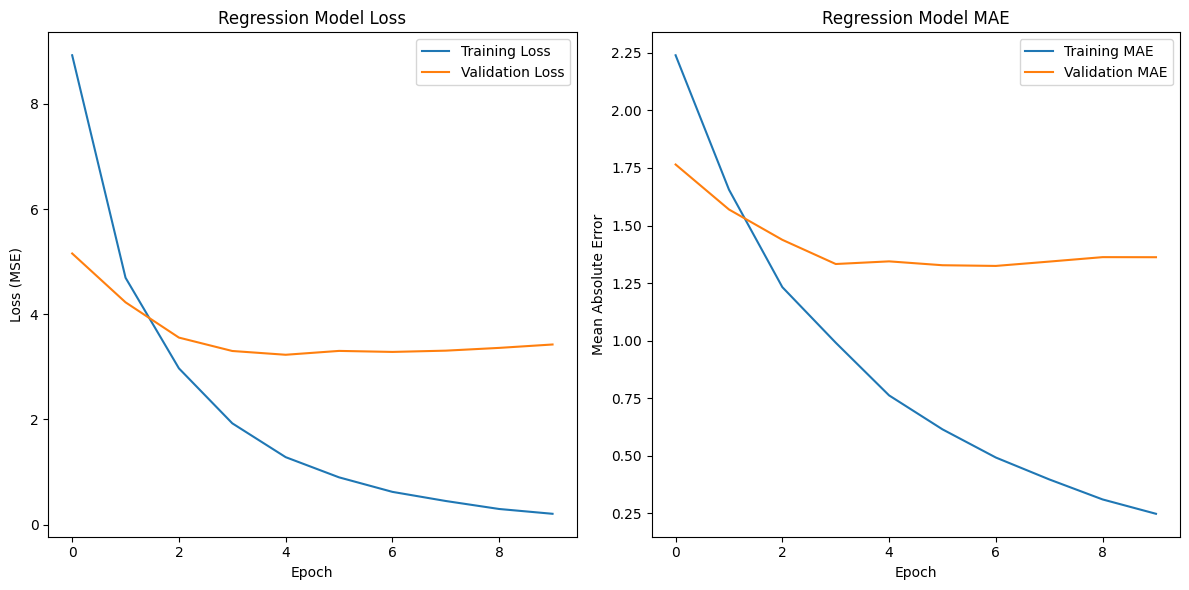

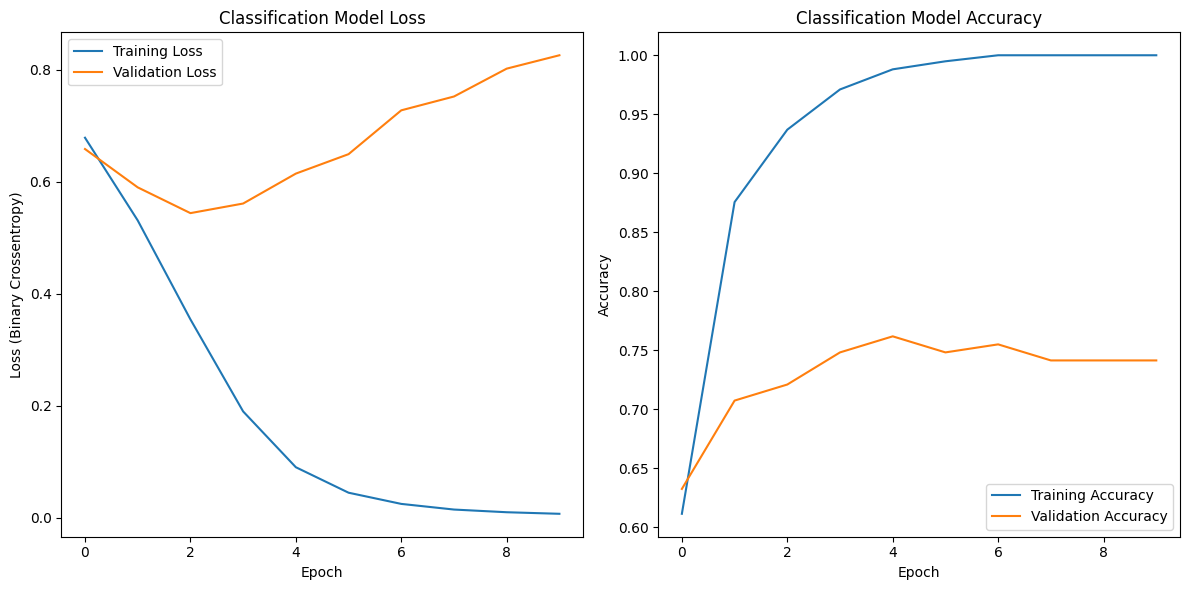

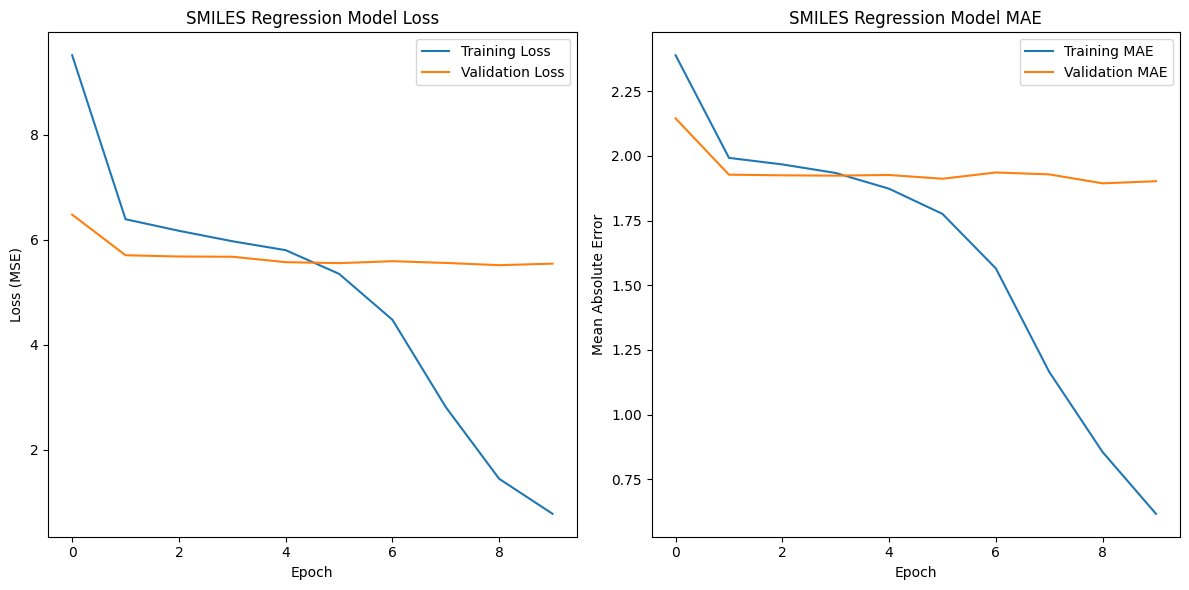

In [7]:
# plot losses and metrics
import matplotlib.pyplot as plt

# Regression models
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Training Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Regression Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_reg.history['mean_absolute_error'], label='Training MAE')
plt.plot(history_reg.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Regression Model MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Classification models
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_class.history['loss'], label='Training Loss')
plt.plot(history_class.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Crossentropy)')
plt.title('Classification Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_class.history['accuracy'], label='Training Accuracy')
plt.plot(history_class.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Model Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# SMILES regression model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_smiles.history['loss'], label='Training Loss')
plt.plot(history_smiles.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('SMILES Regression Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_smiles.history['mean_absolute_error'], label='Training MAE')
plt.plot(history_smiles.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('SMILES Regression Model MAE')
plt.legend()
plt.tight_layout()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


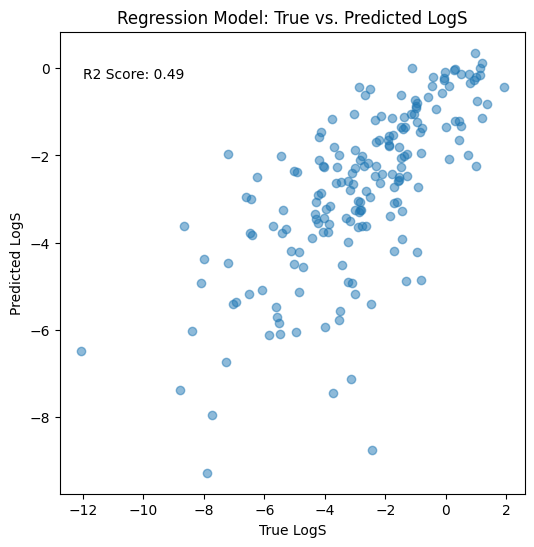

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


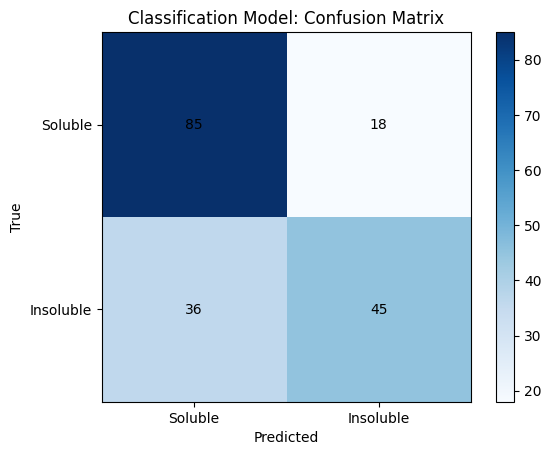

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


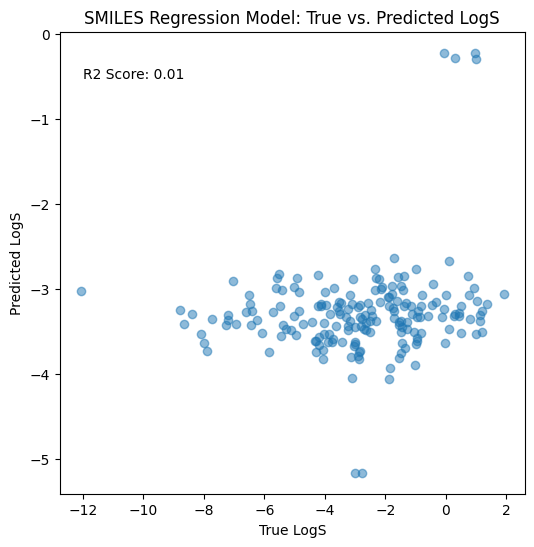

In [8]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

## test set evaluation
# Regression model: scatter plot of predicted vs. true values
y_pred_reg = reg_model.predict(X_test_reg).flatten()
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.annotate(f'R2 Score: {r2_score(y_test_reg, y_pred_reg):.2f}', xy=(0.05, 0.9), xycoords='axes fraction')
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('Regression Model: True vs. Predicted LogS')
plt.show()

# Classification model: confusion matrix
y_pred_class = (class_model.predict(X_test_class) > 0.5).flatten()
cm = confusion_matrix(y_test_class, y_pred_class)
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Classification Model: Confusion Matrix')
plt.xticks([0, 1], ['Soluble', 'Insoluble'])
plt.yticks([0, 1], ['Soluble', 'Insoluble'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

# SMILES regression model: scatter plot of predicted vs. true values
y_pred_smiles = smiles_model.predict(X_test_smiles).flatten()
plt.figure(figsize=(6, 6))
plt.scatter(y_test_smiles, y_pred_smiles, alpha=0.5)
plt.annotate(f'R2 Score: {r2_score(y_test_smiles, y_pred_smiles):.2f}', xy=(0.05, 0.9), xycoords='axes fraction')
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('SMILES Regression Model: True vs. Predicted LogS')
plt.show()
